## ***DS-620 Data Visualization Final Project***
<br>

***Project Contributors:*** Supriya Teegala, Manideep Lenkalapally, Mohamad Sahil & Kuzi Rusere<br><br>
***Business Proposition:*** Providing a Retail Business with a strategy which helps improve their product sales, inventory management, and customer retention, hence improving the profitability of the business. <br>
<br><br>
***Methodology:*** Data Mining, Analysis and Visualization of Retail Sales Data. This will be done mainly using Market Basket Analysis (MBA), which aims to find relationship and establishing pattens within the retail sales data or purchases. MBA looks for relationships or associations among entities and objects that frequently appear together (for example in a retail sales dataset), such as the collection of items in a shopper’s cart.

In [401]:
import chart_studio
username='kkrusere'
api_key='Ef2oYt67aw9nwTQdFBea'
chart_studio.tools.set_credentials_file(username=username,
                                        api_key=api_key)

import chart_studio.plotly as py
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt 
import seaborn as sns
import calendar
import datetime as dt
from wordcloud import WordCloud
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml
from IPython import display
from IPython.core.display import display, HTML

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None 

## **Data cleaning and preprocessing**

In [402]:
#we are going to import the data into a pandas dataframe 
def data_loading(path):
    """
    This function reads the Excel data file from UCI Machinelearning repository 
    The data is stored into a pandas dataframe that the fuction returns  
    """
    df = pd.read_excel(path)
    return df

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

df = data_loading(data_url)

In [403]:
#we will take a look at the data using the pandas '.head()' output the first five rows of the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**General Information About the Data** <br>
This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. <br>

**Information about the Attributes/Columns in the Dataset** <br>

***InvoiceNo:*** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. <br>

***StockCode:*** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>

***Description:*** Product (item) name. Nominal. <br>

***Quantity:*** The quantities of each product (item) per transaction. Numeric.<br>

***InvoiceDate:*** Invice Date and time. Numeric, the day and time when each transaction was generated. <br>

***UnitPrice:*** Unit price. Numeric, Product price per unit in sterling.<br>

***CustomerID:*** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>

***Country:*** Country name. Nominal, the name of the country where each customer resides. <br>

In [404]:
#we are going to use the pandas '.shape' function to the total number of columns and rows of the dataframe 
df.shape

(541909, 8)

We can see that our dataframe contains 541909 rows and 8 columns

In [405]:
#we going to use the pandas '.info()' so see the general infomation (data types, null value count, etc.) about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


From the above we can see that the Description and CustomerID columns have null values, and that the CustomerID has data type float64. 
> * We are going to convert the CustomerID datatype to 'string' and ***Consider*** the null values in this columns ***Guest Customer*** implying that they are customers that do not have Customer IDs.<br> <br>
> * For the null values in the Description column, we are also going to delete the rows, since we do not have any use of them in this particular project.

We are going to create a function that will incompus all the cleanining and modifications that we are going to do to the data.

**What we are going to do to the data frame:**<df>
* Changing the CustomerID to dtype 'object' and replace the null values to 'Guest Customer'.<br><br>
* Remove the rows that have null values from the Description column. we are also going to remove rows that have product description that has length less than or equal to 6 characters, this is because the description are not actually products (well from our understanding). Below is like a sample of some of these descriptions 
>>>>   ['wet?','Damaged','Missing','Discount','lost','MIA','SAMPLES','Display','mailout ','?','missing?','broken','lost??','CARRIAGE','mouldy','smashed']
* Cancelled orders will be removed, since as per the info about the attributes/columns of our dataset, for the 'InvoiceNo' the entries that contain a 'c' is a cancelled order.<br><br>
* We are going to remove the data entries from 2010 and then split the 'Invoice Date' column into just Date (without the time),Time, Month, Day, Week, Day of the Week, Hour, Time of Day (which is either Morning, Afternoon or Evening).We are going to need these to dissect the transations at different periods.<br><br>
* A 'Sales Revenue' column will be created by multiplying the 'Quantity' and 'UnitPrice' columns. This will give the monetery value of each data entry.


In [406]:
type(df.InvoiceDate.dt.year[1])

numpy.int64

In [407]:
def data_cleaning_and_prep(df):
    """  
    This is the Data Cleaning and Preperation Function
    It takes in a dataframe, does the data cleaning and prep and returns dataframe
    """
    ######*****CustomerID column******###########
    #replacing the nan with '0' so that we can convert to int to remove the decimal point
    df["CustomerID"].fillna(0, inplace = True) 
    #converting to int to remove the decimal point
    df['CustomerID'] = df['CustomerID'].astype(int)
    #now to string
    df['CustomerID'] = df['CustomerID'].astype(str)
    #replacing the '0' with Guest Customer
    df["CustomerID"] = df["CustomerID"].replace(to_replace= '0', value= 'Guest Customer')

    ######*****Description column******###########
    #dropping the nan from the Description column
    df.dropna(subset = ['Description'], inplace= True)
    #removing the descriptions with lenth less than or equal to 8 characters
    df.drop(df[df.Description.str.len() <= 8].index, inplace=True)
    #we are going to drop this special case row with description '20713' at index '417090'
    df.drop(df.index[417090], inplace=True)
    #the description to lower case
    df.Description = df.Description.str.lower()
    #we are also going to remove the row that have description value "dotcom postage"
    index_names = df[ df['Description'] == "dotcom postage" ].index
    # drop these row indexes
    # from dataFrame
    df.drop(index_names, inplace = True)

    ######*****InvoiceDate column******###########
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['Year'] = df['InvoiceDate'].dt.year
    #we change the number month to the actual name of the month 
    df['Month'] = df['Month'].apply(lambda x: calendar.month_name[int(x)])
    df['Week of the Year'] = df['InvoiceDate'].dt.isocalendar().week
    #we will add the day of the week to the dataframe 
    df['Day of Week'] = df['InvoiceDate'].dt.day_name()
    df['Time'] = df['InvoiceDate'].dt.time
    df["Hour"] = df['InvoiceDate'].dt.hour
    df['Time of Day']=pd.cut(df['InvoiceDate'].dt.hour,[0,6,12,18,23],labels=['Night','Morning','Afternoon','Evening'],include_lowest=True)
    #lastly here, we will drop the row from the year 2010
    index_names = df[df['Year'] == 2010].index
    df.drop(index_names, inplace = True)
    df.drop('Year', axis=1, inplace=True)

    ######*****InvoiceNo column******#############
    #now we drop the row with cancelled orders
    df['InvoiceNo'] = df['InvoiceNo'].astype(str)
    df.InvoiceNo = df.InvoiceNo.str.lower()
    df = df[~df.InvoiceNo.str.startswith('c')]

    #####*****Sales Revenue column******##########
    #we'll create a column called 'Sales Revenue' = 'Quantity' multiplied by 'UnitPrice'
    df['Sales Revenue'] = df['UnitPrice'] * df['Quantity']

    #####*****Country column******##########
    #we are going to drop the rows that have "Unspecified" country
    df.drop(df[df["Country"] == "Unspecified"].index, inplace = True)

    ###lastly, drop row were the quantity and sales revenue that is less than 0 and drop duplicated rows if any
    index_names = df[df['Quantity'] <= 0].index
    df.drop(index_names, inplace = True)
    index_names = df[df['Sales Revenue'] <= 0].index
    df.drop(index_names, inplace = True)
    df.drop_duplicates(inplace = True)

    return df



At this point we load the clean data using the function above. We are also going to same the data in a csv file for later use the Streamlit application of this project.

In [408]:
df = data_cleaning_and_prep(df)
df.to_csv("Clean_Online_Retail_data.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Month,Week of the Year,Day of Week,Time,Hour,Time of Day,Sales Revenue
42481,539993,22386,jumbo bag pink polkadot,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,19.5
42482,539993,21499,blue polkadot wrap,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
42483,539993,21498,red retrospot wrap,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
42484,539993,22379,recycling bag retrospot,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,10.5
42485,539993,20718,red retrospot shopper bag,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,2011-01-04,January,1,Tuesday,10:00:00,10,Morning,12.5


In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481314 entries, 42481 to 541908
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         481314 non-null  object        
 1   StockCode         481314 non-null  object        
 2   Description       481314 non-null  object        
 3   Quantity          481314 non-null  int64         
 4   InvoiceDate       481314 non-null  datetime64[ns]
 5   UnitPrice         481314 non-null  float64       
 6   CustomerID        481314 non-null  object        
 7   Country           481314 non-null  object        
 8   Date              481314 non-null  object        
 9   Month             481314 non-null  object        
 10  Week of the Year  481314 non-null  UInt32        
 11  Day of Week       481314 non-null  object        
 12  Time              481314 non-null  object        
 13  Hour              481314 non-null  int64         
 14  

## ***Exploratory Data Analysis (EDA)***

* Exploratory data analysis is an approach/practice of analyzing data sets to summarize their main characteristics, often using statistical graphics and other ***data visualization***. It is a critical process of performing initial ***investigations to discover*** patterns, detect outliers and anomalies, and to gain some new, hidden, insight into the data.

* Investigating questions like what the total volume of purchases per month, week, day of the week, time of the day right to the hour. We will look at customers more, later when we get into the ***Customer Profitability Analysis (CPA)*** and the ***Recency, Frequency and Monetary Analysis (RFM)*** sections of the project.

We are going to create a helper fuction that will group the Quantity and Sales Revenue with respect to either the 'CustomerID', 'Country', 'Date', 'Month','Week of the Year', 'Day of Week', 'Hour', or 'Time of Day'.

### ***General EDA***

In [414]:
def group_Quantity_and_SalesRevenue(df,string):
    """ 
    This function inputs the main data frame and feature name 
    The feature name is the column name that you want to group the Quantity and Sales Revenue
    """

    df = df[[f'{string}','Quantity','Sales Revenue']].groupby([f'{string}']).sum().sort_values(by= 'Sales Revenue', ascending = False).reset_index()

    return df

First, we will look at how the Invoices/Purchases are distributed with respect to the customers country. Since this a UK base Online Retailer, the data is going to be highly skewed towards the UK. The first plot will be the top 10 countries with the UK included and the second without the UK.

In [415]:
Country_Data = df.groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country with the UK")
fig.show()

In [419]:
py.plot(fig,kind= 'bar')

UK has more number of orders witk 16k Invoice numbers 

In [413]:
Country_Data = df[df['Country'] != "United Kingdom"].groupby("Country")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(10)
fig = px.bar(Country_Data, x= "InvoiceNo", y='Country', title= "Top 10 Number of orders per country without the UK")
fig.show()


The above charts show that the UK by far has more invoices, just as suspected, with invoices surpassing 15K. Germany in in second place, with approximately 30 time less invoices. The retail store management can start possing question of why this is the case, especially when this is a Online retail store. Question like, what is the traffic like to the store web page, or should they start thinking of ***Search Engine Optimization (SEO)***, which is the process of improving the quality and quantity of website traffic to a website or a web page from search engines. Many other questions can be raised from the 2 charts above.

We can take a look at how the countries fare up with regards to the ***Quantity sold*** and ***Sales Revenue***.The first plot is going to be for Quantity sold and the second will be for Sales Revenue both for the whole year of 2011.

In [185]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Quantity", y='Country', title= "Quantity of orders per country with the UK")
fig.show()

In [186]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Quantity", y='Country', title= "Quantity of orders per country without the UK")
fig.show()

Just as expected, the UK has high volumes of Quantitly sold and the below charts should show that the UK has high sales as well. However, unlike the number of invoices, the Netherlands has the second highest volume of Quantity sold at approximately 200K. 

In [187]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df, x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country with the UK")
fig.show()

In [188]:
temp_df = group_Quantity_and_SalesRevenue(df,'Country')

fig = px.bar(temp_df[temp_df['Country'] != "United Kingdom"], x= "Sales Revenue", y='Country', title= "Sales Revenue of orders per country without the UK")
fig.show()

The sales revenue of Netherlands and Germany is quite close. In the streamlit app of this project, a time filter of this project is used to breakedown by time periods 'Month', 'Week', 'Day of the Week', 'Time of Day' ,or 'Hour'.

We now going to look at the products, which ones have high Quantity sold, or which product has high Sales Revenue. But first the below chart is a wordcloud of the product descriptions. A wordcloud is a visual representations of words that give greater prominence to words that appear more frequently, in this case the frequency is the 'Quantity'

In [189]:
def wordcloud_of_Description(df, title):
    """
    This fuction creates a word cloud
    inputs a data frame converts it to tuples and uses the input 'title' as the title of the word cloud
    """
    plt.rcParams["figure.figsize"] = (20,20)
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [190]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

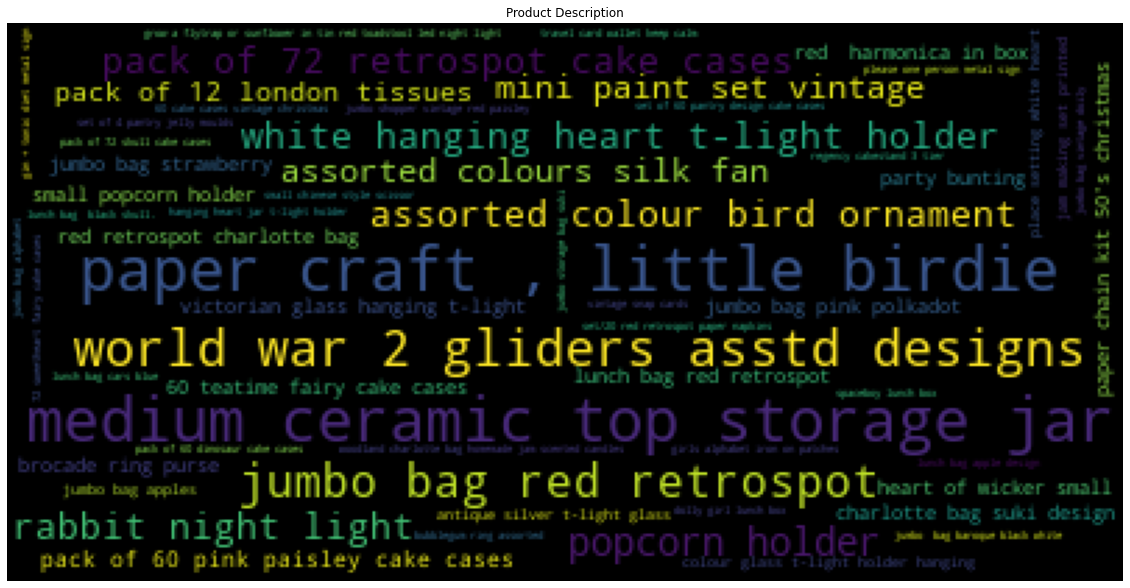

In [191]:
#we can create a word cloud of the product descriptions
temp_df = pd.DataFrame(df.groupby('Description')['Quantity'].sum()).reset_index()
title = "Product Description"
wordcloud_of_Description(temp_df, title)

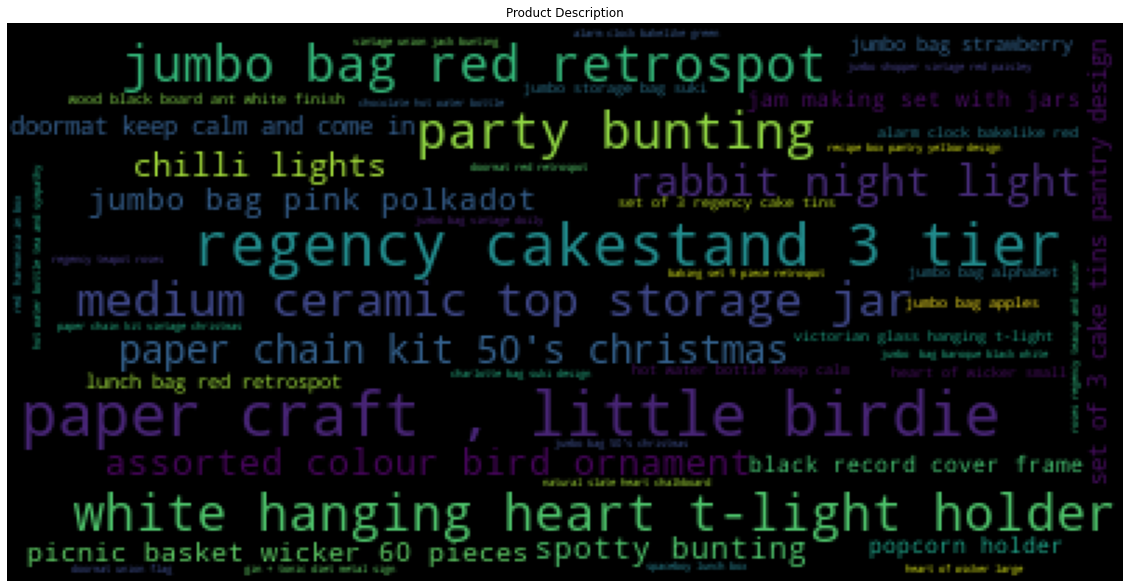

In [192]:
#we can create a word cloud of the product descriptions
temp_df = pd.DataFrame(df.groupby('Description')['Sales Revenue'].sum()).reset_index()
title = "Product Description"
wordcloud_of_Description(temp_df, title)

### ***Monthly Stats*** 

Below are the monthly analysis of the Sales and the Quantity of iterms sold

In [193]:
temp_df = group_Quantity_and_SalesRevenue(df,'Month')

In [194]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Month'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Monthly Sales Revanue and Quantity")
fig.show()

The above graphs show the monthly trend of Quantity of products ordered(left) and Sales Revenue(right). Both the measures were the highest in Novemeber folllowed by October and Septemeber.

In [195]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity per Month", "Sales Revenue per Month")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Month'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Month'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(height=450, width=800, title_text="Percentage pie charts for Monthly Sales Revanue and Quantity")

fig.show()

The above pie charts depicts the quantity of products ordered and sales revenue per month with highest in the month of November with 14.4% and lowest in the month of february with 5.43%.

### ***Weekly Stats*** 

The below are the weekly analysis of the Sales and the Quantity of iterms sold

In [196]:
temp_df = group_Quantity_and_SalesRevenue(df,'Week of the Year')

In [197]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Week of the Year'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(showlegend=False, title_text="Weekly Sales Revanue and Quantity")
fig.show()

The above graphs shows the weekly trend of sales revenue and the quantity of products ordered. The highest peak was on the 49th week in the month of November. As it's a holiday season, there was a high demand for the decoration items. As the quantity increases sales revenue too increases.

### ***Daily Stats*** 

The below are the daily analysis of the Sales and the Quantity of iterms sold

In [198]:
temp_df = group_Quantity_and_SalesRevenue(df,'Day of Week')

In [199]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['Day of Week'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="Day of the Week Sales Revanue and Quantity")
fig.show()

The above graphs depict the daily trend of Sales revenue and quantity. Thursday was observed to generate the highest quantity of products and Sales Revenue.

In [200]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Day of Week'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Day of Week'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(height=400, width=800, title_text="Percentage pie charts for Day of the Week Sales Revanue and Quantity")

fig.show()

The above pie charts shows the daily trend of sales revenue and quantity of products ordered. 

In [201]:
temp_df = group_Quantity_and_SalesRevenue(df,'Time of Day')

In [202]:
fig = make_subplots(rows=1, cols=2,
                    specs=[[{"type": "pie"}, {"type": "pie"}]], 
                    subplot_titles=("Quantity", "Sales Revenue")
                    )

fig.add_trace(
    go.Pie(values = temp_df['Quantity'], labels = temp_df['Time of Day'],
    name = 'Quantity'),
    row=1, col=1
)
fig.add_trace(
    go.Pie(values = temp_df['Sales Revenue'], labels = temp_df['Time of Day'],
    name = 'Sales Revenue'),
    row=1, col=2
)
fig.update_layout(height=400, width=800, title_text="Percentage pie charts for Time of Day Sales Revanue and Quantity")

fig.show()

In [253]:
temp_df = group_Quantity_and_SalesRevenue(df,'CustomerID')

In [256]:
data

,CustomerID,InvoiceNo
0,Guest Customer,1212
1,14911,185
2,12748,171
3,17841,118
4,13089,89
5,14606,83
6,15311,82
7,12971,81
8,14646,70
9,13408,57


In [257]:
data = df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number')
fig.show()

In [254]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=temp_df['CustomerID'], y=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=temp_df['CustomerID'], y=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="Hourly Sales Revenue and Quantity")
fig.show()

The above graphs shows the hourly trend of sales revenue and quantity of products ordered. As expected, the hours between 9 am - 3 pm were found to be the busiest times.

In [205]:
temp_df = group_Quantity_and_SalesRevenue(df, 'Description')

In [206]:
Quantity_tempA = temp_df.sort_values(ascending=False, by = "Quantity").head(10).reset_index(drop=True)
Quantity_tempB = temp_df.sort_values(ascending=False, by = "Quantity").tail(10).reset_index(drop=True)

In [207]:
Quantity_tempA.drop('Sales Revenue', axis=1, inplace=True)
Quantity_tempB.drop('Sales Revenue', axis=1, inplace=True)
display_side_by_side([Quantity_tempA, Quantity_tempB], ['Top 10 Product Description by Quantity', 'Bottom 10 Product Description by Quantity'])

,Description,Quantity
0,"paper craft , little birdie",80995
1,medium ceramic top storage jar,78033
2,world war 2 gliders asstd designs,49660
3,jumbo bag red retrospot,46220
4,popcorn holder,36746
5,white hanging heart t-light holder,34002
6,assorted colour bird ornament,33977
7,pack of 72 retrospot cake cases,32253
8,rabbit night light,30726
9,mini paint set vintage,23923


In [208]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Volume Quantity")

The above graphs depict the top 10 and bottom 10 products by volume quantity. The product paper craft, little birdie was the most popular item whereas orange/fuschia stones necklace was the least popular item.

In [209]:
Sales_Revenue_tempA = temp_df.sort_values(ascending=False, by = "Sales Revenue").head(10).reset_index(drop=True)
Sales_Revenue_tempB = temp_df.sort_values(ascending=False, by = "Sales Revenue").tail(10).reset_index(drop=True)

In [247]:
temp_df = group_Quantity_and_SalesRevenue(df, 'CustomerID')

In [248]:
temp_df

,CustomerID,Quantity,Sales Revenue
0,Guest Customer,371217,1309363.75
1,14646,190131,270561.14
2,18102,57429,231822.69
3,17450,69187,192361.95
4,16446,80997,168472.50
...,...,...,...
4206,16878,12,13.30
4207,17956,1,12.75
4208,14792,2,6.20
4209,16454,2,5.90


In [ ]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Quantity_tempA['Description'], y=Quantity_tempA['Quantity'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Quantity_tempB['Description'], y=Quantity_tempB['Quantity'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Volume Quantity")

In [249]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(y=temp_df['CustomerID'], x=temp_df['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(y=temp_df['CustomerID'], x=temp_df['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="CustomerID Sales Revenue and Quantity with Guest Customer")
fig.show()

In [213]:
X = temp_df[temp_df['CustomerID'] != "Guest Customer"]
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Quantity", "Sales Revenue")
                        )

fig.add_trace(go.Bar(x=X['CustomerID'], y=X['Quantity'],name = 'Quantity'),1, 1)

fig.add_trace(go.Bar(x=X['CustomerID'], y=X['Sales Revenue'],name = 'Sales Revenue'),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Greys'), showlegend=False, title_text="CustomerID Sales Revenue and Quantity without Guest Customer")
fig.show()

In [214]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=False,
                  subplot_titles=("Top 10 Product", "Bottom 10 Products")
                        )

fig.add_trace(go.Bar(x=Sales_Revenue_tempA['Description'], y=Sales_Revenue_tempA['Sales Revenue'],name = 'Top10'),1, 1)

fig.add_trace(go.Bar(x=Sales_Revenue_tempB['Description'], y=Sales_Revenue_tempB['Sales Revenue'],name = 'Bottom10'),1, 2)

fig.update_layout(showlegend=False, title_text="Product Description by Sales Revenue")

In [215]:
temp_df = df[df["CustomerID"] != "Guest_Cusstomer"]
data = temp_df.groupby("CustomerID")["InvoiceNo"].nunique().sort_values(ascending = False).reset_index().head(11)
fig = px.bar(data, x='CustomerID', y='InvoiceNo', title='Graph of top ten customer with respect to the invoice number without the Guest Cusstomer')
fig.show()

The above graphs depict the top 10 and bottom 10 products by sales revenue. The product paper craft, little birdie was found to be generating the highest sales and pads had the lowest sales.

### ***RFM Analysis***

In [216]:
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [217]:
#the first thing that we are going to need is the reference date 
#in this case the day after the last recorded date in the dataset plus a day
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
ref_date 

Timestamp('2011-12-10 12:50:00')

In [218]:
#for RFM we are going to remove the 'Guest Customer' the customers without Customer ID
df_temp = df[df['CustomerID'] != "Guest Customer"]

In [219]:
RFM_df = df_temp.groupby('CustomerID').agg({'InvoiceDate': lambda x: (ref_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'Sales Revenue': lambda x: x.sum()})

RFM_df.columns = ['Recency', 'Frequency', 'Monetary']
RFM_df["R"] = pd.qcut(RFM_df['Recency'].rank(method="first"), 4, labels=[4, 3, 2, 1])
RFM_df["F"] = pd.qcut(RFM_df['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df["M"] = pd.qcut(RFM_df['Monetary'].rank(method="first"), 4, labels=[1, 2, 3, 4])
RFM_df['RFM_Score'] = (RFM_df['R'].astype(int)+RFM_df['F'].astype(int)+RFM_df['M'].astype(int))

RFM_df.reset_index(inplace=True)

RFM_df.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346,326,1,77183.60,1,1,4,6
1,12347,2,6,3598.21,4,4,4,12
2,12348,75,3,784.44,2,3,3,8
3,12349,19,1,1457.55,3,1,3,7
4,12350,310,1,294.40,1,1,1,3
5,12352,36,7,1385.74,3,4,3,10
6,12353,204,1,89.00,1,1,1,3
7,12354,232,1,1079.40,1,1,3,5
8,12355,214,1,459.40,1,1,2,4
9,12356,23,3,2487.43,3,3,4,10


In [220]:
RFM_df[["RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("RFM_Score").agg(["mean", "count"])


Recency        Frequency           Monetary      
                 mean count       mean count         mean count
RFM_Score                                                      
3          242.926056   284   1.000000   284   160.089648   284
4          190.307692   481   1.081081   481   251.621019   481
5          122.896694   484   1.276860   484   361.374548   484
6           85.495108   511   1.534247   511   665.796282   511
7           73.885714   420   2.111905   420   705.211624   420
8           57.110837   406   2.783251   406  1120.774901   406
9           38.282555   407   3.380835   407  1276.003983   407
10          33.617188   384   4.994792   384  2314.164115   384
11          20.085561   374   7.312834   374  3573.616765   374
12           6.938998   459  14.723312   459  8697.529760   459

#### K means Clastering
**We are going to do Kmeans Clustering on CustomerID** using the RFM dataframe that way we can be able group the customers<br>

We will use the **Elbow Graph** to find the best value of the clusters


In [221]:
#now we will use the standard scalr function from SKlean preprocessing and scale transform fit the data (without the Customer Id column)
scaler = StandardScaler()
RFM_df_log = RFM_df[['Recency','Frequency','Monetary','RFM_Score']]
RFM_df_scaled = scaler.fit_transform(RFM_df_log)
RFM_df_scaled = pd.DataFrame(RFM_df_scaled)
RFM_df_scaled.columns = ['Recency','Frequency','Monetary','RFM_Score']

RFM_df_scaled.head()

,Recency,Frequency,Monetary,RFM_Score
0,2.675088,-0.431448,8.758666,-0.534017
1,-0.918657,0.278081,0.192965,1.602052
2,-0.108955,-0.147636,-0.134571,0.178006
3,-0.730096,-0.431448,-0.056218,-0.178006
4,2.497619,-0.431448,-0.191614,-1.602052


In [222]:
the_scores = []
for i in range(2,11): #we will explore from 2 to 10 clusters
  kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
  kmeans.fit(RFM_df_scaled)
  the_scores.append(kmeans.inertia_)

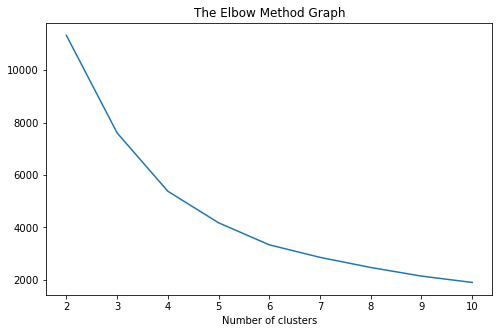

In [223]:
#lets plot the Elbow
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(range(2,11,1),the_scores)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.xticks(ticks=range(2,11))
plt.show()

From the Elbow graph, it looks like we should be using 4 clusters, but to verfy, we will calculate the ‘silhouette_score’ for our clusters. Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.1 means clusters are well apart from each other and clearly distinguished.0 means clusters are indifferent, or we can say that the distance between clusters is not significant and -1 means clusters are assigned in the wrong way.



In [224]:
#calculating the silhouette_score from the sklearn metrics module function silhouette_score
for i in range(2,11): 
  kmeans = KMeans(n_clusters=i, init='k-means++',n_init=10,max_iter=50,verbose=0)
  kmeans.fit(RFM_df_scaled)
  silhouette = silhouette_score(RFM_df_scaled,kmeans.labels_)
  print("for {} clusters the silhouette_score is {}".format(i,silhouette))

for 2 clusters the silhouette_score is 0.4302392161250798
for 3 clusters the silhouette_score is 0.4595416195299859
for 4 clusters the silhouette_score is 0.46055542752397727
for 5 clusters the silhouette_score is 0.466849690348457
for 6 clusters the silhouette_score is 0.4725446054156525
for 7 clusters the silhouette_score is 0.4163353995483013
for 8 clusters the silhouette_score is 0.401074044213681
for 9 clusters the silhouette_score is 0.40318305896693607
for 10 clusters the silhouette_score is 0.403463961555767


From the above and using best judgment, we are going to use 4 clusters.

In [225]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init=10,max_iter=50,verbose=0)
kmeans.fit(RFM_df_scaled)

KMeans(max_iter=50, n_clusters=4)

We will add the clusters to the RFM dataframe

In [226]:
RFM_df['Clusters'] = kmeans.labels_

RFM_df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score,Clusters
0,12346,326,1,77183.60,1,1,4,6,2
1,12347,2,6,3598.21,4,4,4,12,1
2,12348,75,3,784.44,2,3,3,8,0
3,12349,19,1,1457.55,3,1,3,7,0
4,12350,310,1,294.40,1,1,1,3,2


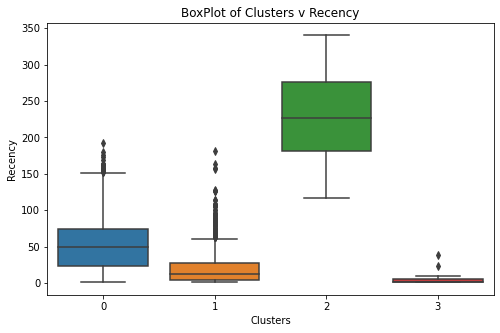

In [227]:
sns.boxplot( x= 'Clusters',y= 'Recency' ,data=RFM_df)
plt.title("BoxPlot of Clusters v Recency")
plt.show()

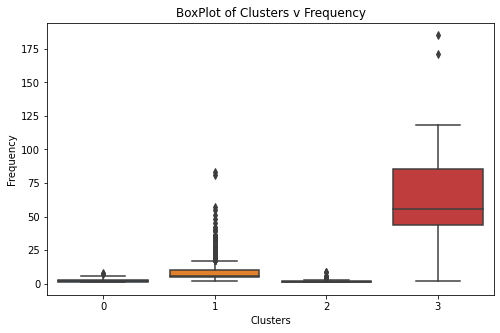

In [228]:
sns.boxplot( x= 'Clusters',y= 'Frequency' ,data=RFM_df)
plt.title("BoxPlot of Clusters v Frequency")
plt.show()

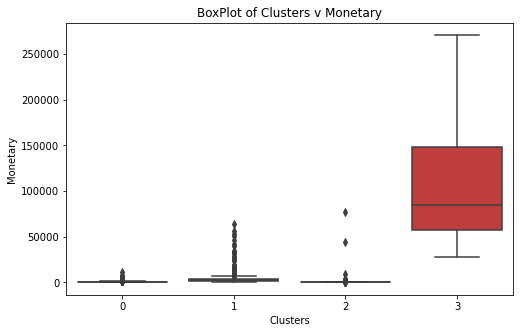

In [229]:
sns.boxplot( x= 'Clusters',y= 'Monetary' ,data=RFM_df)
plt.title("BoxPlot of Clusters v Monetary")
plt.show()

In [260]:
temp_df = RFM_df[["Clusters","RFM_Score", "Recency", "Frequency", "Monetary"]].groupby("Clusters").agg(["mean"])
temp_df.columns = ["RFM_Score mean", "Recency mean", "Frequency mean", "Monetary mean"]
temp_df

,RFM_Score mean,Recency mean,Frequency mean,Monetary mean
Clusters,,,,
0,6.903258,53.388471,2.068170,681.543951
1,11.028783,20.284539,8.588816,3794.843396
2,4.284553,229.500000,1.397358,532.001586
3,11.733333,6.733333,71.000000,111454.533333


In [262]:
specs = [[{'type':'domain'}, {'type':'domain'}], [{'type':'domain'}, {'type':'domain'}]]
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("RFM_Score", "Recency", "Frequency","Monetary"),
                    specs=specs
                    )

fig.add_trace(
    go.Pie(values = temp_df['RFM_Score mean'], labels = temp_df.index,
    name = 'RFM_Score'),
    1, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Recency mean'], labels = temp_df.index,
    name = 'Recency'),
    1, 2
)
fig.add_trace(
    go.Pie(values = temp_df['Frequency mean'], labels = temp_df.index,
    name = 'Frequency'),
    2, 1
)
fig.add_trace(
    go.Pie(values = temp_df['Monetary mean'], labels = temp_df.index,
    name = 'Monetary'),
    2, 2
)
fig.update_layout(height=800, width=800, title_text=" ")
fig.show()

The above pie charts show the percent representation by each cluster with respect to the RFM metrics. The customers in the 'blue cluster' have a high average monetary value and high average frequency. The recency of customers in the 'blue cluster'is very low among the 4 cluster with on 2.3%. The 'red cluster' contains customers a very low monetery value of 3.1%, a recency of 6.52% and a frequency of 10.1%, this by far are the customers with poor metrics; however, they are better that 'purple' and 'green' customer as far as monetary value is concerned. These red customers, at a glance, are probably customers that the store has had for a long period,but starting to lose interest in the store, these customes can be prime candidate for targeted promotions. The management has to drill down on the group of customer looking at what they purchase and find best ways to reel them back. They can even do a filter Market Basket Analysis just for these customers. The 'purple' customers have a high recency and low monetary value and frequency, these might be new customers, management target promotions for this group to entice them to purchase more and frequently. The green customers are somewhat similar to 'red' customers, but with very less monetary value of 0.566%. A filtered MBA can help uncover the buying habits of these customers, in turn can bring up some ideas on how to improve monetary and frequency of this group.

## ***Market Basket Analysis (MBA)***

We are going to re-order and group the Quantity column by the invoice number and the product description for the stated country.

In [263]:
#for the UK we will call this the UKbasket
country = "United Kingdom"


basket = (df[df['Country'] == country]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [264]:
basket.head()

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
540004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [265]:
#from the above table we are going to make that very value that is less than or equal to 0 be zero and anything else be equal to 1.
#this is called one hot encoding and we will use the buit in pandas applymap() function with a custom function as input to check the condition stated above
def encoder(num):
    if num <= 0: return 0
    if num >= 1: return 1

#now we encode
basket = basket.applymap(encoder)

In [266]:
basket.head(5)

Description,4 purple flock dinner candles,50's christmas gift bag large,dolly girl beaker,i love london mini backpack,nine drawer office tidy,oval wall mirror diamante,red spot gift bag large,set 2 tea towels i love london,spaceboy baby gift set,toadstool bedside light,...,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
539993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
540004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The next step will be to generate the frequent itemsets that have a support of at least 10% using the MLxtend Apriori fuction which returns frequent itemsets from a one-hot DataFrame

In [267]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

In [268]:
frequent_itemsets.head(5)

,support,itemsets
0,0.010988,( set 2 tea towels i love london )
1,0.014448,(10 colour spaceboy pen)
2,0.012748,(12 message cards with envelopes)
3,0.017544,(12 pencil small tube woodland)
4,0.017180,(12 pencils small tube red retrospot)


In [279]:
#we then can look at the rules  of association using the MLxtend association_rules() 
#the function generates a DataFrame of association rules including the metrics 'score', 'confidence', and 'lift'
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(6 ribbons rustic charm),(jam making set printed),0.047775,0.053846,0.011473,0.240152,4.460013,0.008901,1.245190
1,(jam making set printed),(6 ribbons rustic charm),0.053846,0.047775,0.011473,0.213078,4.460013,0.008901,1.210062
2,(jam making set with jars),(6 ribbons rustic charm),0.054878,0.047775,0.010381,0.189159,3.959366,0.007759,1.174367
3,(6 ribbons rustic charm),(jam making set with jars),0.047775,0.054878,0.010381,0.217281,3.959366,0.007759,1.207486
4,(6 ribbons rustic charm),(jumbo bag red retrospot),0.047775,0.110666,0.011413,0.238882,2.158585,0.006126,1.168457


In [273]:
import random
import networkx as nx 

In [270]:
# Sort values based on confidence

rules = rules.sort_values("lift",ascending=False)

In [278]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4141,"(herb marker rosemary, herb marker parsley)","(herb marker mint, herb marker thyme)",0.011655,0.011230,0.010199,0.887500,77.912838,0.010068,7.910156
4136,"(herb marker mint, herb marker thyme)","(herb marker rosemary, herb marker parsley)",0.011230,0.011655,0.017699,0.900608,77.912838,0.010068,10.755514
4137,"(herb marker mint, herb marker rosemary)","(herb marker thyme, herb marker parsley)",0.011595,0.011473,0.005199,0.892081,76.663176,0.010065,8.209069
4140,"(herb marker thyme, herb marker parsley)","(herb marker mint, herb marker rosemary)",0.011473,0.011595,0.020199,0.901389,76.663176,0.010065,8.895647
4127,"(herb marker rosemary, herb marker parsley)","(herb marker basil, herb marker thyme)",0.011655,0.011291,0.002516,0.866875,76.110131,0.009885,7.030818
...,...,...,...,...,...,...,...,...,...
996,(paper chain kit 50's christmas ),(jumbo bag red retrospot),0.058520,0.110666,0.005684,0.187573,1.649763,0.004208,1.087967
1817,(white hanging heart t-light holder),(regency cakestand 3 tier),0.117708,0.092819,0.012969,0.160156,1.644671,0.007043,1.070618
1816,(regency cakestand 3 tier),(white hanging heart t-light holder),0.092819,0.117708,0.022969,0.188591,1.644671,0.007043,1.094100
1021,(jumbo bag red retrospot),(regency cakestand 3 tier),0.110666,0.092819,0.008841,0.137569,1.347452,0.003569,1.036860


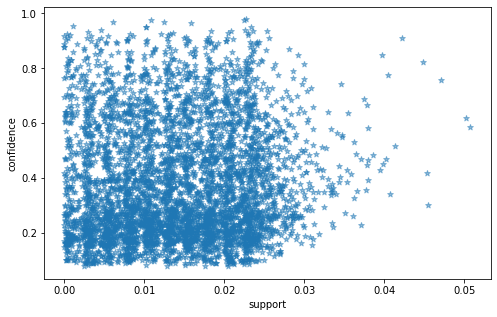

In [275]:
support=rules['support'].to_numpy()
confidence=rules['confidence'].to_numpy()
lift=rules['lift'].to_numpy()
for i in range (len(support)):
   support[i] = support[i] + 0.0025 * (random.randint(1,10) - 5) 
   confidence[i] = confidence[i] + 0.0025 * (random.randint(1,10) - 5)
 
plt.scatter(support, confidence,   alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [280]:
rules.head(4)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(6 ribbons rustic charm),(jam making set printed),0.047775,0.053846,0.011473,0.240152,4.460013,0.008901,1.245190
1,(jam making set printed),(6 ribbons rustic charm),0.053846,0.047775,0.011473,0.213078,4.460013,0.008901,1.210062
2,(jam making set with jars),(6 ribbons rustic charm),0.054878,0.047775,0.010381,0.189159,3.959366,0.007759,1.174367
3,(6 ribbons rustic charm),(jam making set with jars),0.047775,0.054878,0.010381,0.217281,3.959366,0.007759,1.207486


In [290]:
G1 = nx.DiGraph()

In [291]:
color_map=[]
N = 50
colors = np.random.rand(N)    
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   


In [292]:
for i in range (10):      
    G1.add_nodes_from(["R"+str(i)])
    
     
    for a in rules.iloc[i]['antecedents']:
                
        G1.add_nodes_from([a])
        
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
     
       
    for c in rules.iloc[i]['consequents']:
             
            G1.add_nodes_from([c])
            
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)

In [293]:
G1.edges()

OutEdgeView([('R0', 'jam making set printed'), ('6 ribbons rustic charm', 'R0'), ('6 ribbons rustic charm', 'R3'), ('6 ribbons rustic charm', 'R4'), ('6 ribbons rustic charm', 'R7'), ('6 ribbons rustic charm', 'R8'), ('jam making set printed', 'R1'), ('R1', '6 ribbons rustic charm'), ('R2', '6 ribbons rustic charm'), ('jam making set with jars', 'R2'), ('R3', 'jam making set with jars'), ('R4', 'jumbo bag red retrospot'), ('jumbo bag red retrospot', 'R5'), ('R5', '6 ribbons rustic charm'), ('R6', '6 ribbons rustic charm'), ('natural slate heart chalkboard ', 'R6'), ('R7', 'natural slate heart chalkboard '), ('R8', 'pack of 72 retrospot cake cases'), ('pack of 72 retrospot cake cases', 'R9'), ('R9', '6 ribbons rustic charm')])

In [285]:
def draw_graph(rules, rules_to_show):
   
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   
   
   
  for i in range (rules_to_show):
          G1.add_nodes_from(["R"+str(i)])
          for a in rules.iloc[i]['antecedents']:
               G1.add_nodes_from([a])
               G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
          
          for c in rules.iloc[i]['consequents']:
               G1.add_nodes_from([c])
               G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
          
          for node in G1:
               found_a_string = False
               for item in strs:
                    if node==item:
                         found_a_string = True
               if found_a_string:
                    color_map.append('yellow')
               else:
                    color_map.append('green')       
          
 
   
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
          pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()

ValueError: Received invalid argument(s): edges

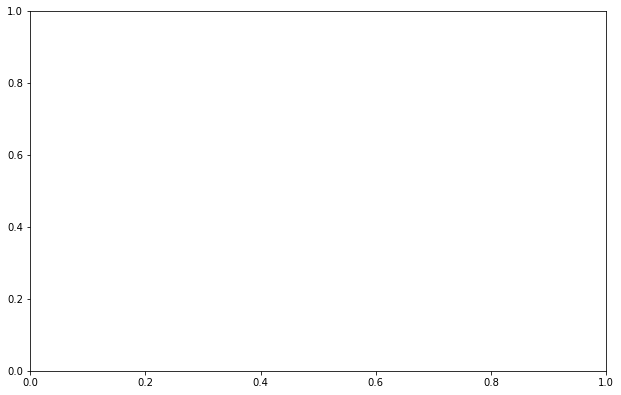

In [286]:
draw_graph(rules, 10) 

In [282]:
rules.iloc[2]['antecedents']

frozenset({'jam making set with jars'})